Os seguintes scripts são uma versão Python do curso de Machine Learning do professor Andrew Ng da universidade de Stanford leccionado na plataforma Coursera.

**Nota: Todos os dados e estrutura do exercício pertencem à Universidade de Stanford**

**Ressalva:** Os scripts não estão implementados de forma modular para todas as funções serem consultadas no mesmo Jupyter Notebook - ao contrário da implementação Octave.

# Exercício1 - Regressão Linear Regularizada

In [1]:
# Importar as libraries do numpy para lidar com matrizes e vectores
import numpy as np
# Importar o pandas para ler ficheiros
import pandas as pd
# Importar o matplotlib para fazer um gráfico dos dados
import matplotlib.pyplot as plt

# Importar o módulo de matemática
import math 

# Importar a função de optimização do scipy
from scipy import optimize, io
from scipy.ndimage import rotate

# Matplotlib notebook property
%matplotlib inline

In [2]:
# Usar o scipy para carregar as matrizes originais
ex5_file = io.loadmat('ex5data1.mat')

# Ler os dados de treino
X = np.array(ex5_file['X'])
y = np.array(ex5_file['y'])

# Ler os dados de teste
X_test = np.array(ex5_file['Xtest'])
y_test = np.array(ex5_file['ytest'])

# Assignar o conjunto de validação
X_val = np.array(ex5_file['Xval'])
y_val = np.array(ex5_file['yval'])

print('# exemplos de treino: {}'.format(len(X)))
m = len(X)

# exemplos de treino: 12


Os dados consistem em informação bruta retirado de uma barragem com o objecto de prever a quantidade de água que está a sair do aqueduto com base no nível de água nos depísitos. Neste exercício vamos dar mais um passo na compreensão da regularização, além de compreendermos o trade-off entre modelos com demasiada variância ou demasiado enviesamento.

In [3]:
def graficoDados(
    X: np.array,
    y: np.array
) -> None:
    '''
    Produz gráfico 2-D dos dados. 
    
    Args:
        X(np.array): Vector original de features.
        y(np.array): Valores target para cada observação no Vector X
    Returns:
        None
    '''
    plt.scatter(X, y, marker='X', color='red')
    plt.xlabel('Mudança no nível da água (x)')
    plt.ylabel('Água a sair da barragem (y)')

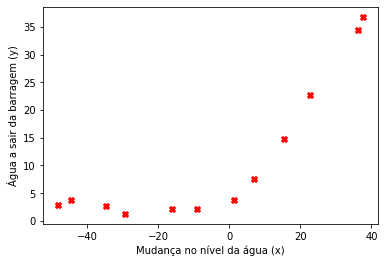

In [4]:
# Gráfico 2-D dos dados
graficoDados(X,y)

Visualizando o gráfico 2-D podemos verificar o comportamento estável da variável y até ao ponto 0 da variável X - até esse ponto a variabilidade na variável y é muito reduzida. Depois de passarmos o ponto 0 na mudança no nível de água, a variável y exibe um comportamento aproximadamente exponencial.

Treinando uma regressão linear apenas com a variável original não nos irá ajudar porque irá, possivelmente, sobre-estimar os valores de y iniciais em função de x e sub-estimar os valores de Y quando X fica maior. Vamos verificar abaixo qual o potencial efeito de treinar uma regressão linear nestes dados.

<br>
A função de custo para a regressao logística regularizada é a seguinte: 

<img src="assets/CostFunction.JPG">

E a fórmula do gradiente:

<img src="assets/GradientRegularizedLinearRegression.JPG">

<b>Como vimos noutras aulas, um valor maior de lambda aumenta a penalização dos coeficientes no modelo, reduzindo o "overfitting" do modelo.

In [5]:
# Definir a função de custo e de gradiente

def regLinearFuncaoCusto(
    theta: np.array, 
    X: np.array, 
    y: np.array,
    lambdas: int
) -> [float, np.array]:
    '''
    Calcula a função de custo e o gradiente para um conjunto de thetas.
    
    Args:
        theta(np.array): Conjunto de thetas(pesos) para aplicar às features X
        X(np.array): Conjunto original de features.
        y(np.array): Valores target para as observações de X.
        lambdas(int): Parâmetro de regularização.
        
    Retorna:
        J(float): Função de erro - neste caso usamos o erro quadrado médio.
        grad(np.array): O gradiente dos Thetas em função à minimização de J.
    '''
    # Redimensionar o Theta
    theta = theta.reshape(theta.shape[0],1)
    
    # Adicionar o vector de 1's (bias term)
    vector_uns = np.ones((len(X),1))
    X_ext = np.hstack((vector_uns,X)) 
    
    # Calcular o número de exemplos X
    m = len(y)
    # Calcular a hipótese
    h = np.dot(theta.T.reshape(1,theta.shape[0]), X_ext.T)
    
    # Calcular o erro
    erro = h.T - y

    # Calcular a função de custo
    J = sum(erro**2)/(2*m) + lambdas/(2*m)*sum(theta[1:]**2)
    # Calcular o gradiente regularizado e
    grad = np.dot(erro.T,X_ext) / m + np.append(np.array(0), (lambdas/m*theta[1:]))
    
    return J, grad

In [6]:
# Initicializar um theta
theta = np.array([1,1])
# Redimensionar o vector original
theta = theta.reshape(len(theta),1)

# Verificar a função de custo e o gradiente para os thetas iniciais
J, grad = regLinearFuncaoCusto(theta,X,y, 1)

In [7]:
print('A função de custo para o theta [1,1] é {}'.format(float(J)))

A função de custo para o theta [1,1] é 303.9931922202643


In [8]:
print('O gradiente aplicar ao theta [1,1] é {}, {}'.format(float(grad[:,0]), float(grad[:,1])))

O gradiente aplicar ao theta [1,1] é -15.303015674201186, 598.2507441727037


Vamos então minizar a nossa função de custo:

In [9]:
# Treinar a regressão linear

# implementação baseada no user Gerges Dib (github user:dibgerge) - 
# usamos a library scipy para optimizar a função de custo. 
# Minimizamos a função de custo começando no Theta initial_theta 
# TNC significa Truncated Newton Algorithm e o máximo de iterações que 
# vamos fazer face ao mínimo da função de custo são 200
def treinarRegressaoLinear(
    regLinearFuncaoCusto: callable, 
    X: np.array, 
    y: np.array, 
    lambda_:int
) -> np.array:
    
    '''
    Treina a regressão linear, minimizando a função de custo(erro)
    e retorna os thetas óptimos encontrados.
    
    Args:
        regLinearFuncaoCusto(callable): Função usada para calcular
        uma iteração da função de custo e do gradiente.
        X(np.array): Valores originais das features X.
        y(np.array): Valores target das features X.
        lambda_(int): Parâmetro de regularização.
        
    Retorna:
        res.x(np.array): Thetas optimos encontrados 
        pelo método de optimização.
    '''
 
    theta_inicial = np.zeros((X.shape[1]+1,1))

    options= {'maxiter': 200}

    res = optimize.minimize(regLinearFuncaoCusto,
                            theta_inicial,
                            (X,y,lambda_),
                            jac=True,
                            method='TNC',
                            options=options)
    
    return res.x

In [10]:
opt_theta = treinarRegressaoLinear(regLinearFuncaoCusto, X, y, 0)
print('Theta óptimo encontrado pela optimização: {}'.format(opt_theta))

Theta óptimo encontrado pela optimização: [13.08790351  0.36777923]


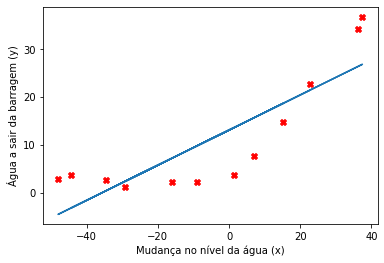

In [11]:
# Adicionar o vector de uns para o gráfico de dados
vector_uns = np.ones((len(X),1))
X_ext = np.hstack((vector_uns,X))
    
# Gráfico 2-D com as variáveis X e Y
# Colocar a linha correspondente à regressão linear treinada
graficoDados(X,y)
plt.plot(X_ext[:,1],np.dot(opt_theta.T,X_ext.T))

Como os nossos pontos não seguem uma tendência linear, a nossa regressão não conseguiu capturar os efeitos da variável y em X mesmo minimizando o custo. Em 2D é fácil compreendermos isto mas na maioria dos casos temos de utilizar outras técnicas para compreender este efeito nos modelos de machine learning, principalmente quando falamos em casos de maior dimensionamento.

O nosso modelo mostra um caso clássico de um modelo com um alto enviesamento. O oposto disto seria um modelo com elevada variância em que a linha se ajustava de forma quase perfeita aos nossos casos de treino, podendo não generalizar para novos casos (outras barragens, por exemplo).

Uma técnica utilizada para analisar o enviesamento vs. variância consiste em colocar num gráfico as curvas de aprendizagem do algoritmo. Além de vermos isto no próximo exercício vamos também introduzir o contexto de conjunto de validação - este conjunto é um conjunto denovos dados que o modelo não viu durante o treino - em quase todo os tipos de problemas de machine learning, o que irá sempre contar é a capacidade do modelo ser aplicado em dados nunca antes vistos - sendo esta uma métrica essencial para aferir a qualidade de previsão do mesmo. As curvas de aprendizagem ajudam-nos a compreender o comportamento do nosso erro ao longo de todo o processo de treino de um algoritmo.

# Exercício 2 - Gráfico de Curvas de Aprendizagem

In [12]:
# Definir o novo lambda

lambda_ = 0

# Definir a função das curvas de aprendizagem
def curvasAprendizagem(
    regLinearFuncaoCusto, 
    X: np.array, 
    y: np.array, 
    X_val: np.array, 
    y_val: np.array, 
    lambda_: int
) -> [np.array, np.array]:
    
    '''
    Coloca num gráfico o erro de treino de uma regressão 
    logística treinada sob m exemplos.
    
    Args:
        regLinearFuncaoCusto(callable): Função que computa o custo
        e o gradiente.
        X(np.array): Valores originais das features X.
        y(np.array): Valores Target das observações X.
        X_val(np.array): Valores originais das features dos dados não
        vistos pelo modelo.
        y_val(np.array): Valores originais do target de dados não 
        vistos pelo modelo.
        lambda_(int): Parâmetros de regularização.
        
    Returns:
        error_train(float): Erro do modelo treinado nos dados de treino.
        error_val(float): Erro do conjunto de validação do modelo treinado.
    '''

    # Número de exemplos de treino
    m = len(X)

    # Placeholders para os valores de erro
    erro_treino = np.zeros((m,1))
    erro_val = np.zeros((m,1))

    # Treinar a regressão linear de 0 até m exemplos

    for i in range(0,m):
        # Seleccionar apenas m exemplos das tabelas
        batch_features = X[0:i+1, :]
        batch_target = y[0:i+1,:]

        # Obter o theta optimo para os exemplos fornecidos e obter a função de custo para esse theta
        theta_train = treinarRegressaoLinear(regLinearFuncaoCusto, batch_features, batch_target, lambda_)
        iter_j_train = regLinearFuncaoCusto(theta_train, batch_features, batch_target, lambda_)

        # Verificar o erro no conjunto de validação
        iter_j_val = regLinearFuncaoCusto(theta_train, X_val, y_val, lambda_)
        # Assinar o erro ao placeholder correspondente
        erro_treino[i] = iter_j_train[0]
        erro_val[i] = iter_j_val[0]

    return erro_treino, erro_val

In [13]:
# Obter as curvas de aprendizagem
erro_treino, erro_val = curvasAprendizagem(regLinearFuncaoCusto, X, y, X_val, y_val, 0)

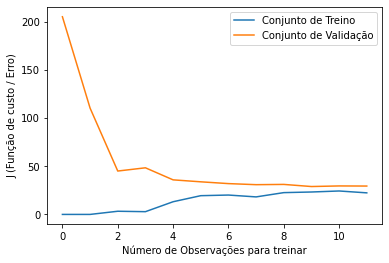

In [14]:
# Verificar graficamente o erro de validação e de treino
plt.plot(erro_treino)
plt.plot(erro_val)
plt.xlabel('Número de Observações para treinar')
plt.ylabel('J (Função de custo / Erro)')
plt.legend(['Conjunto de Treino','Conjunto de Validação'])

O erro aumenta à medida que vamos acrescentando mais dados ao treino - tipicamente esta evolução acontece quando temos um modelo com um elevado enviesamento - principalmente quando vemos um erro um pouco elevado à medida que acrescentamos dados para treino o modelo. Se a diferença entre o conjunto de treino e de validação fosse muito elevada estariamos perante um modelo com elevada variância. 

As features que temos, provavelmente, nunca irão capturar os efeitos da variável y. Vamos criar outro tipo de features para tentar melhorar a performance do nosso modelo.

# Exercício 3 - Regressão Polinomial

Com "features" polinomiais poderemos, possívelmente, capturar alguns dos efeitos não-lineares da variável y. 

In [15]:
# Definir a ordem polinomial

p = 8 

def featuresPolinomiais(
    X: np.array, 
    p:int
)-> np.array: 
    '''
    Calcula as features polinomiais até à ordem p 
    do vector X.
    
    Args:
        X(np.array): Dados originais.
        p(int): Grau limite para calcular polinomiais.
    Retorna: 
        X_poly(np.array): Features polinomiais da variável X
    '''
    # Adicionar a coluna de uns 
    X_poli = np.zeros((X.shape[0], p))
    for i in range(1,p+1):
        # Elevar X à potência i 
        X_poli[:,i-1] = (X ** i).reshape(len(X))

    return X_poli

In [16]:
# Calcular features polinomiais
X_poli = featuresPolinomiais(X,8)

In [17]:
# Como as features polinomiais têm escalas completamente diferentes
# Vamos ter de normalizar os valores
def normalizarFeatures(
    X: np.array, 
    media=[],
    desvpad=[]
) -> np.array:
    '''
    Normaliza as features ao subtrair a média e dividir 
    o valor pelo desvio-padrão.
    
    Args:
        X(np.array): Valores originais da variável X.
        media(list): Vector com a média das variáveis.
        desvpad(list): Vector com os desvios-padrão das variáveis.
    Returns:
        X_estandardizada(np.array): Valores estandardizados da variável X.
        media(np.array): Vector com as médias das variáveis estandardizadas.
        desvpad(np.array): Vector com os desv-pad das variáveis estandardizadas.
    '''
    # Se não dermos a média à funções, calculamos a média e desvio padrão
    if len(media) == 0:
        media = np.mean(X, axis=0)
        # Para nos equipararmos ao cálculo do octave usamos 1 grau de liberdade
        desvpad = np.std(X, axis=0, ddof=1)
        
    X_estandardizada = (X - media)/desvpad
    return X_estandardizada, media, desvpad

In [18]:
X_poli, media, desvpad = normalizarFeatures(X_poli)

In [19]:
# Normalizar o conjunto de teste usando os dados de treino.
X_poli_teste = featuresPolinomiais(X_test,p)
X_poli_teste, _, _ = normalizarFeatures(X_poli_teste, media, desvpad)

In [20]:
X_poli_val = featuresPolinomiais(X_val,p)
X_poli_val, _ ,_ = normalizarFeatures(X_poli_val, media, desvpad)

# Adicionar o vector de uns ao conjunto de validação
vector_uns = np.ones((len(X_poli_val),1))
X_poli_val_ext = np.hstack((vector_uns,X_poli_val)) 

Vamos treinar a regressão com as features polinomiais. Naturalmente, a linha não será linear.

**A fórmula da nossa regressão polinomial é a seguinte:**

<img src="assets/PolynomialRegression.JPG">

In [21]:
opt_theta_poli = treinarRegressaoLinear(regLinearFuncaoCusto, X_poli, y, 100)

print('Theta óptimo encontrado pela optimização: {}'.format((opt_theta_poli)))

Theta óptimo encontrado pela optimização: [11.21758935  0.96420878  0.32296631  0.74742798  0.14423032  0.5558083
  0.02028321  0.41869296 -0.05800437]


In [22]:
def graficoPolinomial(
    theta_optimo: np.array,
    media: np.array,
    desvpad: np.array,
    n: int, 
    p: int,
    X: np.array, 
    y: np.array
) -> None:
    '''
    Constrói gráfico da regressão polinomial para uma amostra
    de n pontos.
    
    Args:
        theta_optimo(np.array): Theta óptimo retornado pela optimização da
        função de custo.
        media(np.array): Vector de médias.
        desvpad(np.array): Vector de desvios-padrão.
        n(int): # observações.
        p(int): Grau polinomial máximo.
        X(np.array): Vector original de features.
        y(np.array): Vector de valores target.
    
    Retorna:
        None
    '''
    
    eixo_x = np.linspace(min(X)-15,max(X)+25,2512)

    xmat = featuresPolinomiais(eixo_x,p)
    
    xmat, _, _ = normalizarFeatures(xmat, media, desvpad)
    
    # Adicionar o vector de uns
    vector_uns = np.ones((len(xmat),1))
    xmat = np.hstack((vector_uns,xmat))     
    #print(xmat)
    graficoDados(X,y)
    
    h = np.dot(xmat,theta_optimo.reshape(theta_optimo.shape[0],1))
    plt.plot(eixo_x,h,'b--')
    
    plt.legend(['Linha resultante do treino da regressão', 'Dados Reais'])

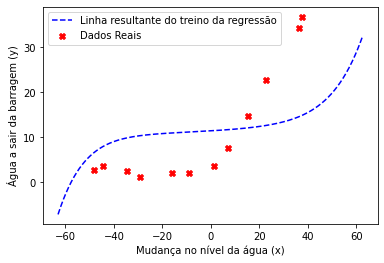

In [23]:
graficoPolinomial(opt_theta_poli,media,desvpad,100, 8, X, y)

# Exercício 4 - Tradeoff Enviesamento vs. Variância

In [24]:
# Obter as curvas de aprendizagem para a regressão polinomial
erro_treino_poli, erro_val_poli = curvasAprendizagem(regLinearFuncaoCusto, X_poli, y, X_poli_val, y_val, 100)

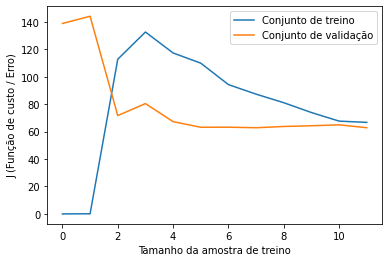

In [25]:
# Verificar a função de custo nos conjuntos de treino e validação com um lambda de 100
plt.plot(erro_treino_poli)
plt.plot(erro_val_poli)
plt.xlabel('Tamanho da amostra de treino')
plt.ylabel('J (Função de custo / Erro)')
plt.legend(['Conjunto de treino','Conjunto de validação'])

A curva de aprendizagem é completamente diferente da curva de aprendizagem da regressão treinada com as features originais. A função de custo é mais elevada na maior parte das iterações já que os efeitos dos dados reais ainda não estão a ser capturados. E se colocarmos a regularização para 0?

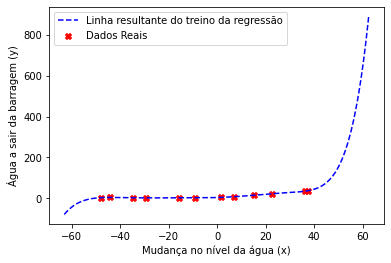

In [26]:
opt_theta_poli_lambda_0 = treinarRegressaoLinear(regLinearFuncaoCusto, X_poli, y, 0)
graficoPolinomial(opt_theta_poli_lambda_0,media,desvpad,100, 8, X, y)

A linha treinada ajustou-se perfeitamente aos pontos da curva. Agora a questão prende-se no aparecimento de novos pontos em que os dados não foram treinados. Com uma linha tão "colada" aos dados de treino, existe o risco de não termos um modelo generalizável.

In [27]:
# Obter as curvas de aprendizagem com um lambda = 0
erro_treino_poli_lambda_0, erro_val_polo_lambda_0 = curvasAprendizagem(regLinearFuncaoCusto, X_poli, y, X_poli_val, y_val, 1)

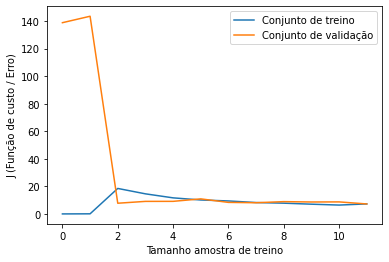

In [28]:
plt.plot(erro_treino_poli_lambda_0)
plt.plot(erro_val_polo_lambda_0)
plt.xlabel('Tamanho amostra de treino')
plt.ylabel('J (Função de custo / Erro)')
plt.legend(['Conjunto de treino','Conjunto de validação'])

Agora, a questão prende-se: Como podemos seleccionar um lambda óptimo? 

In [29]:
def curvaValidacao(
    regLinearFuncaoCusto: callable, 
    X: np.array, 
    y: np.array, 
    X_val: np.array, 
    y_val: np.array
) -> [np.array, np.array]:
    '''
    Calcula os erros para o conjunto de treino e validação
    para diferentes lambdas.
    
    Args:
        regLinearFuncaoCusto(callable): Função utilizada
        para calcular uma iteração da função de custo e gradiente.
        X(np.array): Vector original de features.
        y(np.array): Vector com valores target.
        X_val(np.array): Vector original de features do conjunto de validação.
        y_val(np.array): Vector com valores target do conjunto de validação.
    '''
    lambda_vec = np.array([0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10])
    m = len(lambda_vec)
    
    # Placeholders para colocarmos os erros durante as iterações
    erro_treino = np.zeros((m,1))
    erro_val = np.zeros((m,1))
    
    for i in range(0,m):
        opt_theta = treinarRegressaoLinear(regLinearFuncaoCusto, X, y, lambda_vec[i])
        j_train = regLinearFuncaoCusto(opt_theta, X, y, lambda_vec[i])[0]
        
        erro_treino[i] = j_train
        
        j_val = regLinearFuncaoCusto(opt_theta, X_val, y_val, lambda_vec[i])[0]
        
        erro_val[i] = j_val
        
    return erro_treino, erro_val

In [30]:
erro_treino_lambda, erro_val_lambda = curvaValidacao(regLinearFuncaoCusto, X_poli, y, X_poli_val, y_val)

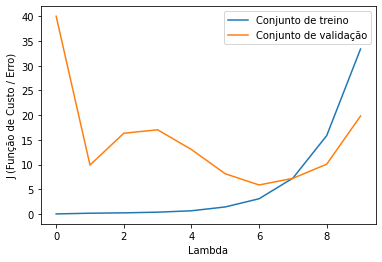

In [31]:
# Calcular a função de custo ao longo dos diversos lambdas
plt.plot(erro_treino_lambda)
plt.plot(erro_val_lambda)
plt.xlabel('Lambda')
plt.ylabel('J (Função de Custo / Erro)')
plt.legend(['Conjunto de treino','Conjunto de validação'])

Iterar através de vários lambdas ajuda-nos a compreender o efeito da regularização na função de custo e a escolher o lambda óptimo. No lambda = 7 é onde encontramos um cruzamento entre as linhas do erro do conjunto de treino e teste e onde potencialmente conseguimos um equilíbrio entre enviesamento e variância. Se quisermos um modelo mais acertado mas com uma maior probabilidade de overfit também podemos utilizar um lambda de 6 já que o erro não varia muito entre os dois conjuntos.

<br>**Visualizando a nossa regressão com um lambda = 6:**

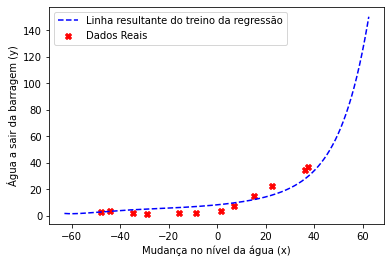

In [32]:
opt_theta_lambda_6 = treinarRegressaoLinear(regLinearFuncaoCusto, X_poli, y, 6)
graficoPolinomial(opt_theta_lambda_6,media,desvpad,100, 8, X, y)